In [18]:
%matplotlib inline

In [19]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [20]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [21]:
print(x_train, y_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [5 0 4 ... 8 4 8]


In [22]:
print(x_valid, y_valid)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [3 8 6 ... 5 6 8]


(50000, 784)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


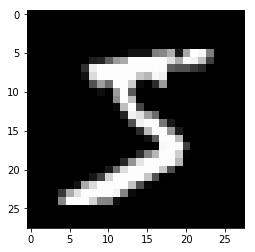

In [23]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)
print(x_train)

In [24]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## Neural network from scratch

In [28]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
print(weights.shape)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

torch.Size([784, 10])


In [29]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [30]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-1.8586, -2.8066, -2.4974, -2.8487, -2.6327, -1.9153, -2.4812, -1.6598,
        -2.9575, -2.3175], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [31]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [32]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.2646, grad_fn=<NegBackward>)


In [37]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    print(preds)
    return (preds == yb).float().mean()

In [38]:
#print(preds)
print(yb)
print(accuracy(preds, yb))

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])
tensor([7, 5, 3, 9, 9, 5, 9, 5, 9, 0, 7, 3, 7, 3, 9, 9, 5, 9, 7, 7, 3, 9, 7, 9,
        9, 3, 7, 7, 7, 7, 7, 9, 8, 7, 7, 7, 9, 5, 7, 6, 9, 7, 9, 7, 7, 9, 9, 7,
        5, 7, 7, 9, 7, 7, 9, 7, 9, 7, 3, 9, 3, 7, 0, 9])
tensor(0.1094)


In [44]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        # print(f"start: {start_i}  end: {end_i}")
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [42]:
print(n)
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

50000
tensor([9, 3, 7, 0, 9, 0, 8, 5, 5, 2, 4, 5, 0, 8, 4, 8])
tensor(0.0809, grad_fn=<NegBackward>) tensor(1.)


## Using torch.nn.functional

In [45]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias


In [46]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor([9, 3, 7, 0, 9, 0, 8, 5, 5, 2, 4, 5, 0, 8, 4, 8])
tensor(0.0603, grad_fn=<NllLossBackward>) tensor(1.)


In [47]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias


In [48]:
model = Mnist_Logistic()

In [49]:
print(loss_func(model(xb), yb))


tensor(2.3443, grad_fn=<NllLossBackward>)


In [50]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [51]:
print(loss_func(model(xb), yb))

tensor(0.0811, grad_fn=<NllLossBackward>)


## Refactor using nn.Linear

In [52]:
nn.Linear?
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

Init signature: nn.Linear(in_features, out_features, bias=True)
Docstring:     
Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

Args:
    in_features: size of each input sample
    out_features: size of each output sample
    bias: If set to False, the layer will not learn an additive bias.
        Default: ``True``

Shape:
    - Input: :math:`(N, *, \text{in\_features})` where :math:`*` means any number of
      additional dimensions
    - Output: :math:`(N, *, \text{out\_features})` where all but the last dimension
      are the same shape as the input.

Attributes:
    weight: the learnable weights of the module of shape
        :math:`(\text{out\_features}, \text{in\_features})`. The values are
        initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`, where
        :math:`k = \frac{1}{\text{in\_features}}`
    bias:   the learnable bias of the module of shape :math:`(\text{out\_features})`.
            If :attr:`bias` is ``True``, the values are

In [53]:
nn.Conv2d?

Init signature:
nn.Conv2d(
    ['in_channels', 'out_channels', 'kernel_size', 'stride=1', 'padding=0', 'dilation=1', 'groups=1', 'bias=True'],
)
Docstring:     
Applies a 2D convolution over an input signal composed of several input
planes.

In the simplest case, the output value of the layer with input size
:math:`(N, C_{\text{in}}, H, W)` and output :math:`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`
can be precisely described as:

.. math::
    \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
    \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)


where :math:`\star` is the valid 2D `cross-correlation`_ operator,
:math:`N` is a batch size, :math:`C` denotes a number of channels,
:math:`H` is a height of input planes in pixels, and :math:`W` is
width in pixels.

* :attr:`stride` controls the stride for the cross-correlation, a single
  number or a tuple.

* :attr:`padding` controls the amount of implicit zero-pad